<a href="https://colab.research.google.com/github/hrnnikolov/BoardGame/blob/main/model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Getting Data



In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

#Creating Effnetb2 model

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408,
                                              out_features=3))

In [9]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=33):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  transforms = effnetb2_weights.transforms()

  model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408,
                                              out_features=num_classes))

  return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=33)

effnetb2, effnetb2_transforms

(EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activation): Sigmoid()
           )
          

# Creating DataLoaders

In [11]:
from going_modular.going_modular import data_setup
import torchvision

BATCH_SIZE=32

train_dataloader, test_dataloader , class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=effnetb2_transforms,
                                                                                batch_size=BATCH_SIZE)

In [12]:
train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c125fb47d00>,
 ['pizza', 'steak', 'sushi'])

In [13]:
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)

effnetb2_results = engine.train(model=effnetb2,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=10,
             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9518 | train_acc: 0.5604 | test_loss: 0.7435 | test_acc: 0.8767
Epoch: 2 | train_loss: 0.7419 | train_acc: 0.7771 | test_loss: 0.5946 | test_acc: 0.9256
Epoch: 3 | train_loss: 0.5851 | train_acc: 0.8458 | test_loss: 0.5217 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.4683 | train_acc: 0.9062 | test_loss: 0.4302 | test_acc: 0.9381
Epoch: 5 | train_loss: 0.4660 | train_acc: 0.8625 | test_loss: 0.3957 | test_acc: 0.9227
Epoch: 6 | train_loss: 0.3715 | train_acc: 0.9125 | test_loss: 0.3533 | test_acc: 0.9443
Epoch: 7 | train_loss: 0.3343 | train_acc: 0.9229 | test_loss: 0.3432 | test_acc: 0.9443
Epoch: 8 | train_loss: 0.3279 | train_acc: 0.9062 | test_loss: 0.3218 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3041 | train_acc: 0.9354 | test_loss: 0.2966 | test_acc: 0.9443
Epoch: 10 | train_loss: 0.3207 | train_acc: 0.8958 | test_loss: 0.2782 | test_acc: 0.9477


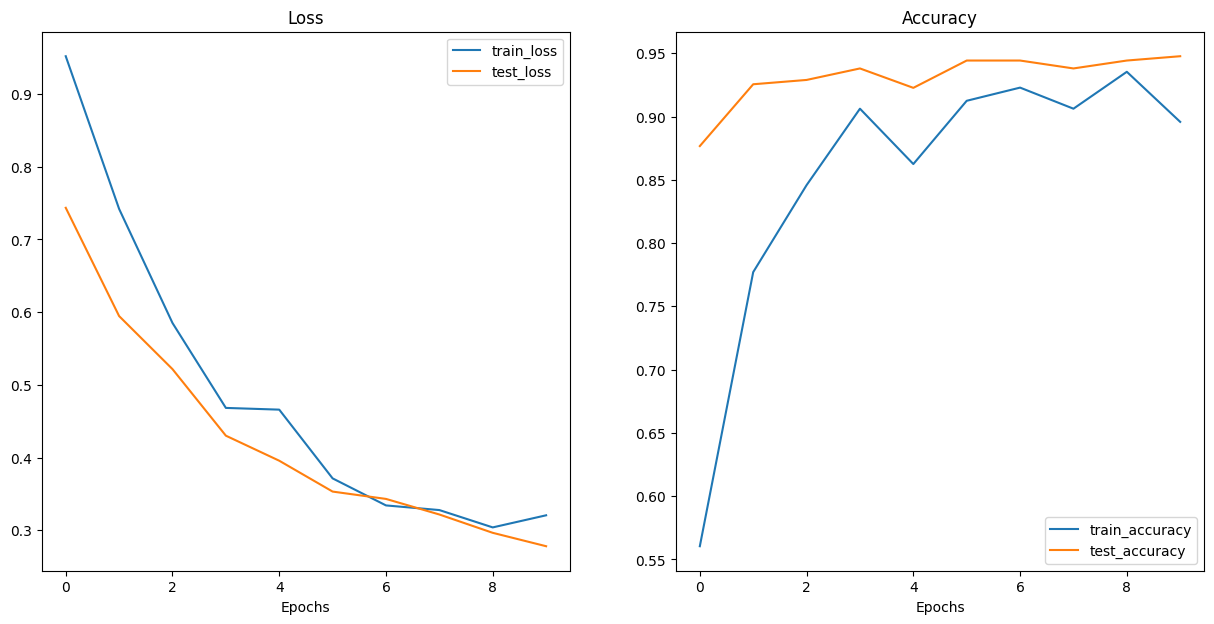

In [14]:
plot_loss_curves(effnetb2_results)

In [15]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [19]:
from pathlib import Path

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size / (1024 * 1024)
print(f'Your model size is {pretrained_effnetb2_model_size:.2f} mb')

Your model size is 29.86 mb


# effnetb2 stats

In [20]:
#num of params
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
# effnetb2 dic stats
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_acc': effnetb2_results['test_acc'][-1],
                  'number_of_parameters': effnetb2_total_params,
                  'model_size (MB)': pretrained_effnetb2_model_size}

effnetb2_stats


{'test_loss': 0.27820318937301636,
 'test_acc': 0.9477272727272726,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

# Creating ViT model

In [50]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [51]:
def create_vitb16_model(num_classes:int=3,
                        seed:int=33):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                         out_features=num_classes))

  return model, transforms

In [57]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [64]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)


In [65]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [66]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


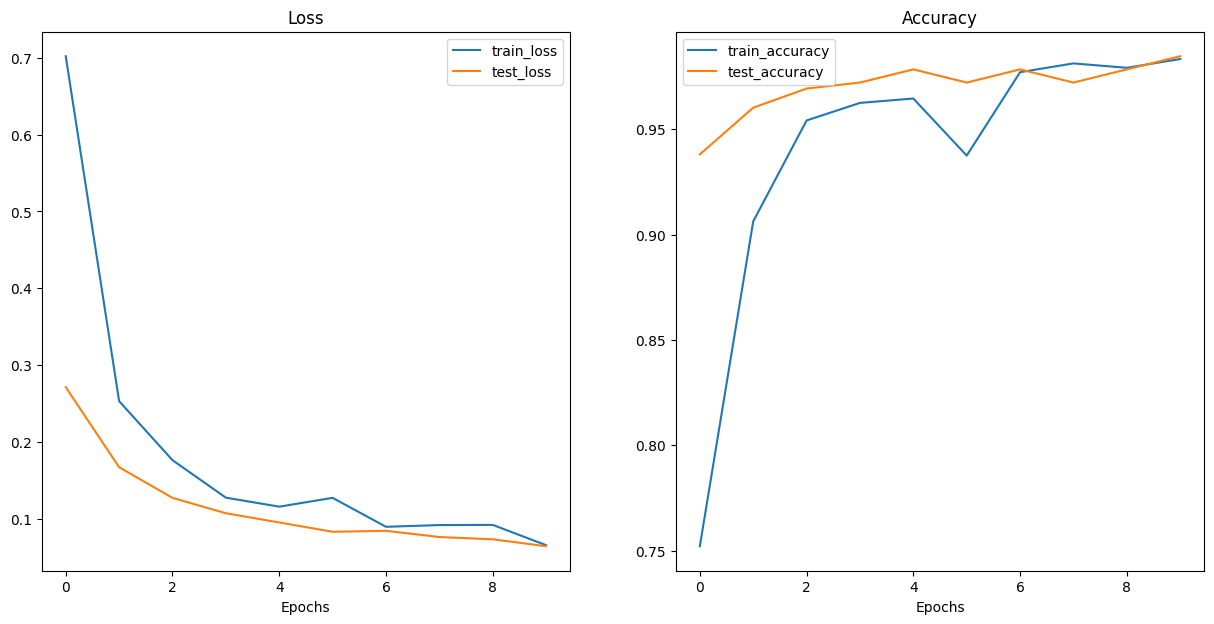

In [67]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [68]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth


In [69]:
from pathlib import Path

pretrained_vit_model_size = Path('models/09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size / (1024 * 1024)
print(f'Your model size is {pretrained_vit_model_size:.2f} mb')

Your model size is 327.37 mb


In [71]:
#num of params
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [72]:
# effnetb2 dic stats
vit_stats = {'test_loss': vit_results['test_loss'][-1],
                  'test_acc': vit_results['test_acc'][-1],
                  'number_of_parameters': vit_total_params,
                  'model_size (MB)': pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3714771270752}

In [74]:
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1655387.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/864661.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/66858.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/697562.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')